### This notebook generates the CAPE-ascent rate relationships for MCSs in the reanalysis-convective tracking data. First import libraries and constants.

In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from scipy import stats
from matplotlib import cm
from numpy import unravel_index

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [2]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air
threshold = 10

## Loading ERA data

In [4]:
# array of years
#years = np.arange( 1983, 2008 )
years = np.arange( 2000, 2003 )

# create list of file names
#file_years = file_concatenator_ERAI(years)
file_years = file_concatenator_ERA5(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
print(np.nanmin(minlat_array))
maxlat_array = nc_open_compile(file_years,"max latitude")
print(np.nanmax(maxlat_array))
tropical_indx = np.argwhere( (minlat_array >= -10) & (maxlat_array <= 10) )[:,0]
tropical_rain_indx = tropical_indx # SS 20250204 adjusted here
#tropical_rain_indx = np.argwhere( (minlat_array >= -10) & (maxlat_array <= 10) & (pmax_array >= np.percentile(pmax_array,75)) )[:,0]
print(tropical_indx.shape)

# applying same for MCS lifetime and morphology
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERA = negative_to_nan(lifetime_array)[tropical_rain_indx]
rad_array = nc_open_compile(file_years,"rad")
rad_ERA = negative_to_nan(rad_array)[tropical_rain_indx]
ctt_array = nc_open_compile(file_years,"ctt")
ctt_ERA = negative_to_nan(ctt_array)[tropical_rain_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERA = negative_to_nan(minctt_array)[tropical_rain_indx]

-33.0
27.0
(103209,)


In [5]:
#pressure level values converted into double point precision
#factor of 100 converts hPa to Pa. we want to use SI units exclusively below.
plev_ERA = np.double((xr.open_dataset(file_years[0])).pressure_level.data) # SS 20250204 "pressure" -> "pressure_level"
print(plev_ERA)
# Read in the vertical velocities
omega_array = nc_open_compile(file_years,"w_mean",'stack')[tropical_rain_indx] # SS 20250204 "omega" -> "w_mean"
# Extract the value at 550 hPa
omega_ERA_mid = omega_array[:,15]
# Extract the value around 200 hPa
omega_ERA_hi = omega_array[:,23]

# creating cape array from different files and treating for negatives
cape_array = nc_open_compile(file_years,"cape_mean") # SS 20250204 "cape" -> "cape_mean"
cape_ERA = negative_to_nan(cape_array)[tropical_rain_indx]
#capepre_array = nc_open_compile(file_years,"capepre")
#capepre_ERA = negative_to_nan(capepre_array)[tropical_rain_indx]
#capepre6_array = nc_open_compile(file_years,"capepre6")
#capepre6_ERA = negative_to_nan(capepre6_array)[tropical_rain_indx]

# Filter for negative values of omega (ascent rates)
omega_ERA_mid_n, cape_ERA_n = negative_vals( omega_ERA_mid, cape_ERA )
omega_ERA_hi_n, _ = negative_vals( omega_ERA_hi, cape_ERA )

#_, capepre6_ERA_n = negative_vals( omega_ERA_mid, capepre6_ERA )
_, rad_ERA_n = negative_vals( omega_ERA_mid, rad_ERA )
_, ctt_ERA_n = negative_vals( omega_ERA_mid, ctt_ERA )
_, minctt_ERA_n = negative_vals( omega_ERA_mid, minctt_ERA )
_, lifetime_ERA_n = negative_vals( omega_ERA_mid, lifetime_ERA )

_, rad_ERA_n2 = negative_vals( omega_ERA_hi, rad_ERA )
_, ctt_ERA_n2 = negative_vals( omega_ERA_hi, ctt_ERA )
_, minctt_ERA_n2 = negative_vals( omega_ERA_hi, minctt_ERA )
_, lifetime_ERA_n2 = negative_vals( omega_ERA_hi, lifetime_ERA )

[1000.  975.  950.  925.  900.  875.  850.  825.  800.  775.  750.  700.
  650.  600.  550.  500.  450.  400.  350.  300.  250.  225.  200.  175.
  150.  125.]


In [6]:
# Filter for positive values of omega (descent rates)
omega_ERA_mid_p, cape_ERA_p = positive_vals( omega_ERA_mid, cape_ERA )
omega_ERA_hi_p, _ = positive_vals( omega_ERA_hi, cape_ERA )

#_, capepre6_ERA_p = positive_vals( omega_ERA_mid, capepre6_ERA )
_, rad_ERA_p = positive_vals( omega_ERA_mid, rad_ERA )
_, ctt_ERA_p = positive_vals( omega_ERA_mid, ctt_ERA )
_, minctt_ERA_p = positive_vals( omega_ERA_mid, minctt_ERA )
_, lifetime_ERA_p = positive_vals( omega_ERA_mid, lifetime_ERA )

_, rad_ERA_p2 = positive_vals( omega_ERA_hi, rad_ERA )
_, ctt_ERA_p2 = positive_vals( omega_ERA_hi, ctt_ERA )
_, minctt_ERA_p2 = positive_vals( omega_ERA_hi, minctt_ERA )
_, lifetime_ERA_p2 = positive_vals( omega_ERA_hi, lifetime_ERA )

In [7]:
nbins = 25
pc2 = 99
maxcape = 3700
cape_bins_ascent, ascent_vals, _, ascent_99_vals, _, ascent_error, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERA_n, omega_ERA_mid_n, pc2=pc2, threshold=threshold ) 
#capepre6_bins_ascent, ascent_vals2, _, ascent_99_vals2, cape_error_ascent2, _, _, _ = \
#    bin_stat_function( nbins, 0, maxcape, capepre6_ERA_n, omega_ERA_mid_n, pc2=pc2, threshold=20 ) 

# create bins in CAPE and evaluate corresponding ascent rate percentiles stratifying by extent
upp = np.percentile( rad_ERA_n, 75 )
loo = np.percentile( rad_ERA_n, 25 )
cape_bins_small, ascent_vals_small, _, ascent_99_vals_small, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERA_n[rad_ERA_n <= loo], omega_ERA_mid_n[rad_ERA_n <= loo], pc2=pc2, threshold=threshold )
cape_bins_large, ascent_vals_large, _, ascent_99_vals_large, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERA_n[rad_ERA_n >= upp], omega_ERA_mid_n[rad_ERA_n >= upp], pc2=pc2, threshold=threshold )

### Look at the scaling of ascent rates against CAPE across different morphologies

In [8]:
def squared(x):
    return x**2

def sqrt(x):
    return np.sqrt(x)

-0.0015469061049629966 0.6776617720378265 1.4967645971098605e-05
-0.0018219743579003553 0.6177406875468788 0.0003066663033193028
-0.002420396483299842 0.8154761525595086 6.929930820615544e-07
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-0.010161083553102059 0.6580508662243943 4.4039326297615144e-05
-0.016286114042229013 0.6861796150536664 7.378318987521083e-05
-0.012018056757968102 0.8184322528183149 1.486130944843029e-06


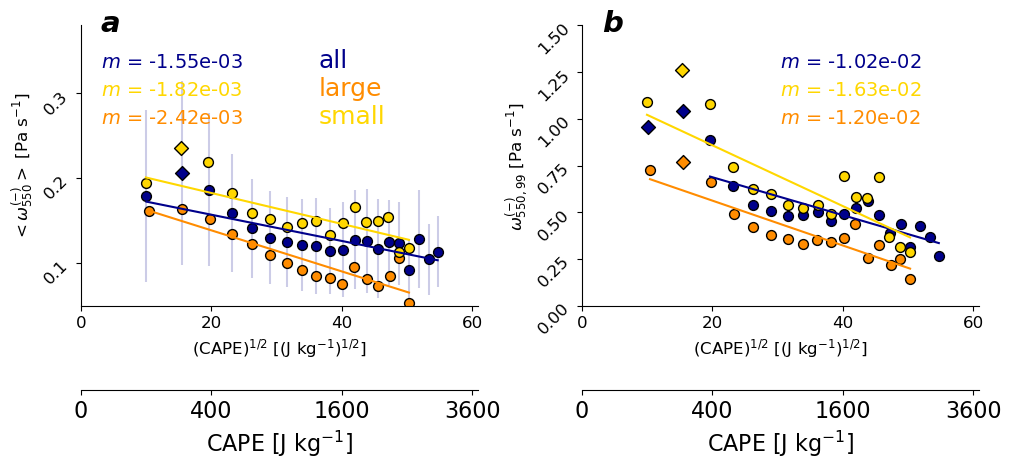

In [9]:
fig, ax = plt.subplots( 1, 2, figsize =(10, 4.5), constrained_layout=True )
sz = 50
lw = 1.5
fs = 18

ylab = [ r'$<\omega_{550}^{(-)}>$ [Pa s$^{-1}$]', '$\omega_{550, 99}^{(-)}$ [Pa s$^{-1}$]' ]
labels = [ r'(CAPE)$^{1/2}$ [(J kg$^{-1})^{1/2}$]', '(CAPE)$^{1/2}$ [(J kg$^{-1})^{1/2}$]' ]
let = [ 'a', 'b' ]
font_size = 16
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flat): 
    axis.set( ylabel = ylab[i] )
    axis.set_xticks( [0, np.sqrt(400), np.sqrt(1600), np.sqrt(3600)] )
    axis.set_xlim( [0, np.sqrt(maxcape)] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    axis.text( 0.05, 0.98, let[i], transform=axis.transAxes, style='italic', fontsize=font_size+5, weight='bold' )
        
    if i == 0:
        out, y_predicted, x_input, zscores = linindx( np.sqrt(cape_bins_ascent), ascent_vals )
        axis.errorbar( np.sqrt(cape_bins_ascent), ascent_vals, yerr=ascent_error/2, 
                      color = 'darkblue', ls='none', zorder=-1, alpha=0.2 )
        markers=['o' if z <= 2 else 'D' for z in zscores]
        for c, a, m in zip(cape_bins_ascent, ascent_vals, markers):
            axis.scatter( np.sqrt(c), a, s=sz, color='darkblue', edgecolor='black', marker=m )
        axis.plot( x_input, y_predicted, color='darkblue', linewidth=lw  )
        axis.text( 0.05, 0.85, r"$m$ = " + f"{out.slope:.2e}", color='darkblue',
                  fontsize=font_size-2, transform=axis.transAxes )
        print(out.slope, out.rvalue**2, out.pvalue)
        
        out, y_predicted, x_input, zscores = linindx( np.sqrt(cape_bins_small), ascent_vals_small )
        markers=['o' if z <= 2 else 'D' for z in zscores]
        for c, a, m in zip(cape_bins_small, ascent_vals_small, markers):
            axis.scatter( np.sqrt(c), a, s=sz, color='gold', edgecolor='black', marker=m )
        axis.plot( x_input, y_predicted, color='gold', linewidth=lw )
        axis.text( 0.05, 0.75, r"$m$ = " + f"{out.slope:.2e}", color='gold',
                  fontsize=font_size-2, transform=axis.transAxes )
        print(out.slope, out.rvalue**2, out.pvalue)
    
        out, y_predicted, x_input, zscores = linindx( np.sqrt(cape_bins_large), ascent_vals_large )
        markers=['o' if z <= 2 else 'D' for z in zscores]
        for c, a, m in zip(cape_bins_large, ascent_vals_large, markers):
            axis.scatter( np.sqrt(c), a, s=sz, color='darkorange', edgecolor='black', zorder=-1, marker=m )
        axis.plot( x_input, y_predicted, color='darkorange', linewidth=lw )
        axis.text( 0.05, 0.65, r"$m$ = " + f"{out.slope:.2e}", color='darkorange',
                  fontsize=font_size-2, transform=axis.transAxes )
        axis.text( 0.6, 0.75, 'large', color='darkorange', fontsize=fs, transform=axis.transAxes )
        axis.text( 0.6, 0.85, 'all', color='darkblue', fontsize=fs, transform=axis.transAxes )
        axis.text( 0.6, 0.65, 'small', color='gold', fontsize=fs, transform=axis.transAxes )

        print(out.slope, out.rvalue**2, out.pvalue)
        
        axis.set_ylim([0.05, 0.38])
        ax2 = axis.secondary_xaxis( -0.3, functions=(squared, sqrt) )
        ax2.set_xticks( [0, 400, 1600, 3600] )
        ax2.set_xlabel( r'CAPE [J kg$^{-1}$]', fontsize=font_size )
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
    elif i == 1:
        out, y_predicted, x_input, zscores = linindx( np.sqrt(cape_bins_ascent), ascent_99_vals )
        markers=['o' if z <= 2 else 'D' for z in zscores]
        for c, a, m in zip(cape_bins_ascent, ascent_99_vals, markers):
            axis.scatter( np.sqrt(c), a, s=sz, color='darkblue', edgecolor='black', marker=m )
        axis.plot( x_input, y_predicted, color='darkblue', linewidth=lw )
        axis.text( 0.5, 0.85, r"$m$ = " + f"{out.slope:.2e}", color='darkblue',
                  fontsize=font_size-2, transform=axis.transAxes )
        print(out.slope, out.rvalue**2, out.pvalue)
        
        out, y_predicted, x_input, zscores = linindx( np.sqrt(cape_bins_small), ascent_99_vals_small )
        markers=['o' if z <= 2 else 'D' for z in zscores]
        for c, a, m in zip(cape_bins_small, ascent_99_vals_small, markers):
            axis.scatter( np.sqrt(c), a, s=sz, color='gold', edgecolor='black', marker=m )
        axis.plot( x_input, y_predicted, color='gold', linewidth=lw )
        axis.text( 0.5, 0.75, r"$m$ = " + f"{out.slope:.2e}", color='gold',
                  fontsize=font_size-2, transform=axis.transAxes )
        print(out.slope, out.rvalue**2, out.pvalue)
        
        out, y_predicted, x_input, zscores = linindx( np.sqrt(cape_bins_large), ascent_99_vals_large )
        markers=['o' if z <= 2 else 'D' for z in zscores]
        for c, a, m in zip(cape_bins_large, ascent_99_vals_large, markers):
            axis.scatter( np.sqrt(c), a, s=sz, color='darkorange', edgecolor='black', marker=m )
        axis.plot( x_input, y_predicted, color='darkorange', linewidth=lw )
        axis.text( 0.5, 0.65, r"$m$ = " + f"{out.slope:.2e}", color='darkorange',
                  fontsize=font_size-2, transform=axis.transAxes )
        print(out.slope, out.rvalue**2, out.pvalue)
        
        axis.set_ylim([0, 1.5])
        ax2 = axis.secondary_xaxis( -0.3, functions=(squared, sqrt) )
        ax2.set_xticks( [0, 400, 1600, 3600] )
        ax2.set_xlabel( r'CAPE [J kg$^{-1}$]', fontsize=font_size )     

#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/ascent-CAPE-ERA-percentiles.pdf', bbox_inches='tight' )
plt.show() 